# Predicción Emplazamientos

### Cargar Paquetes

In [1]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker()
tracker.start()

[codecarbon INFO @ 11:40:04] [setup] RAM Tracking...
[codecarbon INFO @ 11:40:04] [setup] GPU Tracking...
[codecarbon INFO @ 11:40:05] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:40:05] [setup] CPU Tracking...
[codecarbon WARNING @ 11:40:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 11:40:06] We saw that you have a 12th Gen Intel(R) Core(TM) i7-12700H but we don't know it. Please contact us.
[codecarbon INFO @ 11:40:06] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i7-12700H


ref: C:\Users\Brais\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\data\hardware\cpu_power.csv


[codecarbon INFO @ 11:40:07] >>> Tracker's metadata:
[codecarbon INFO @ 11:40:07]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 11:40:07]   Python version: 3.11.9
[codecarbon INFO @ 11:40:07]   CodeCarbon version: 2.6.0
[codecarbon INFO @ 11:40:07]   Available RAM : 15.627 GB
[codecarbon INFO @ 11:40:07]   CPU count: 20
[codecarbon INFO @ 11:40:07]   CPU model: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 11:40:07]   GPU count: 1
[codecarbon INFO @ 11:40:07]   GPU model: 1 x NVIDIA GeForce RTX 3050 Laptop GPU
[codecarbon INFO @ 11:40:07] Saving emissions data to file c:\Users\Brais\Desktop\Hackathon\TreeRegressor\emissions.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor
from datetime import timedelta


### Definir Funciones

In [3]:
def check_time_gaps(df: pd.DataFrame) -> None:
    """
    Revisa si faltan fechas

    Parametros:
    
    df (pd.DataFrame): DataFrame con columna 'time'.

    Returns:
    
    None
    """
    # Create a full range of dates from the minimum to the maximum date in the 'time' column
    full_range = pd.date_range(df["time"].min(), df["time"].max())
    # Find the dates that are missing in the 'time' column
    missing_dates = full_range.difference(df["time"])
    
    if len(missing_dates) > 0:
        print("There are time gaps")
        print(missing_dates)
        return missing_dates
    else: 
        print("full dataset")

def plot_predictions(test_target, y_pred):
    for i in range(2):
        plt.subplot(2, 1, i + 1)
        # Plot actual validation data
        plt.plot(np.arange(0, len(test_target)), test_target[:, i], label='Validation Actual', color='green', alpha=0.6)
        
        # Plot predictions for validation data
        plt.plot(np.arange(0, len(test_target)), y_pred[:, i], label='Validation Predicted', color='red', alpha=0.7)
        
        plt.title(f'Target Variable {i + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

def mae_cal(test_target, y_pred):
    error_24h = 0
    error_48h = 0
    for x,y in zip(test_target, y_pred):
        error_24h += abs(x[0] - y[0])
        error_48h += abs(x[1] - y[1])
    error_24h = error_24h/len(test_target)
    error_48h = error_48h/len(test_target)
    return error_24h, error_48h

def create_future_arrays(column):
    future_values = []
    for i in range(len(column)):
        if i < len(column) - 2:
            future_values.append([column[i + 1], column[i + 2]])
        elif i == len(column) - 2:
            future_values.append([column[i + 1], None])  # Only next day available
        else:
            future_values.append([None, None])  # No future values available
    return future_values

def create_zero_dataframe(n=200):
    zero_df = pd.DataFrame({
        'time': [None] * n,  # You can choose how to handle the 'time' column
        'caudal': [0] * n,
        'velocity': [0] * n,
        'acceleration': [0] * n,
        'target': [[0, 0]] * n
    })
    return zero_df

def haversine(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

def get_nearest_points(df, target_lat, target_lon, n=10):
    # Calculate distance and add it to the DataFrame
    df = df.copy()
    df['distance'] = df.apply(lambda row: haversine(target_lat, target_lon, row['latitude'], row['longitude']), axis=1)
    
    # Return the n smallest distances
    nearest_points = df.nsmallest(n, 'distance')
    return nearest_points

def weighted_mean(df, weights):
    """ Calculate weighted mean for a DataFrame using given weights """
    return (df * weights).sum() / weights.sum()

def mean_for_nearest_points(df, points, n=4):
    mean_daily_dfs = []

    for target_lat, target_lon in points:
        # Get the nearest points with distances
        nearest_points = get_nearest_points(df, target_lat, target_lon, n)

        # Calculate inverse distance weights (closer points get higher weights)
        nearest_points['weight'] = 1 / nearest_points['distance']

        nearest_data = pd.DataFrame()
        for index, point in nearest_points.iterrows():
            point_data = df[(df['latitude'] == point['latitude']) & (df['longitude'] == point['longitude'])].copy()

            # Safely modify the copy of point_data
            point_data['weight'] = point['weight']  # Add the weight to each row

            nearest_data = pd.concat([nearest_data, point_data], ignore_index=True)

        # Drop unnecessary columns from nearest_data (if they exist)
        drop_columns = [col for col in ['latitude', 'longitude', 'distance', 'weight', 'date'] if col in nearest_data.columns]

        # Calculate weighted mean by date
        def weighted_mean(values, weights):
            return np.average(values, weights=weights)

        # Applying weighted mean to all numeric columns, excluding categorical columns like 'date'
        mean_daily = nearest_data.groupby('date').apply(
            lambda group: pd.Series({
                col: weighted_mean(group[col], group['weight']) for col in group.columns if col not in drop_columns
            })
        ).reset_index()

        mean_daily['target_latitude'] = target_lat  
        mean_daily['target_longitude'] = target_lon  

        mean_daily_dfs.append(mean_daily)

    result_df = pd.concat(mean_daily_dfs, ignore_index=True)

    # Finally, take the average across all target points
    final_df = result_df.groupby('date').mean(numeric_only=True).reset_index()

    return final_df

### Preprocesar Datos Emplazamiento

In [4]:
# Load data and pivot
emplazamientos = pd.read_csv("../data/target_emplazamientos_train.csv", parse_dates = ["time"])
test_dates = check_time_gaps(emplazamientos)
dates_for_pred = [date - pd.DateOffset(days=1) for date in test_dates[::2]]
emplazamientos = emplazamientos.pivot_table(index='time', columns='name', values='caudal_m3/s').reset_index()

# Rename columns and ensure 'time' is in datetime format
emplazamientos.columns.name = None  
emplazamientos.columns = ['time'] + [f'caudal_{col}' for col in emplazamientos.columns[1:]]
emplazamientos['time'] = pd.to_datetime(emplazamientos['time'])

# Generate full date range and merge it into the original DataFrame
full_date_range = pd.date_range(start=emplazamientos['time'].min(), end=emplazamientos['time'].max(), freq='D')
full_dates_df = pd.DataFrame(full_date_range, columns=['time'])

# Efficient left merge and fill missing values with 0 for caudal columns
emplazamientos = pd.merge(full_dates_df, emplazamientos, on='time', how='left').fillna(0)

# Sort and reset index
emplazamientos = emplazamientos.sort_values(by='time').reset_index(drop=True)

# Initialize lists for velocity and acceleration columns
velocity_columns = []
acceleration_columns = []

# Calculate velocity and acceleration
for col in emplazamientos.columns[1:]:  # Skipping 'time' column
    # Calculate velocity
    velocity_col_name = f'velocity_{col}'
    emplazamientos[velocity_col_name] = emplazamientos[col].diff().fillna(0)
    velocity_columns.append(velocity_col_name)

    # Calculate acceleration
    acceleration_col_name = f'acceleration_{col}'
    emplazamientos[acceleration_col_name] = emplazamientos[velocity_col_name].diff().fillna(0)
    acceleration_columns.append(acceleration_col_name)

# Order columns: time -> caudal -> velocity -> acceleration
ordered_columns = ['time']  
for col in emplazamientos.columns[1:]:  # Skip 'time' and dynamically order columns
    if 'caudal' in col:
        ordered_columns.append(col)
        ordered_columns.append(f'velocity_{col}')
        ordered_columns.append(f'acceleration_{col}')

# Ensure all columns are present before reordering
ordered_columns = [col for col in ordered_columns if col in emplazamientos.columns]

emplazamientos = emplazamientos[ordered_columns]

emplazamientos = emplazamientos.iloc[:,:16]

for i in range(5):  # Assuming 5 emplazamientos
    emplazamientos[f'target_Emplazamiento {i}'] = create_future_arrays(emplazamientos[f'caudal_Emplazamiento {i}'])
    
dates = ['2022-03-27', '2023-03-26', '2023-04-10',
               '2023-04-12', '2023-05-01', '2023-05-03',
               '2023-06-06', '2023-06-08', '2023-07-03', 
               '2023-07-05', '2023-07-29', '2023-07-31', 
               '2023-09-03', '2023-09-05', '2023-09-24', 
               '2023-09-26', '2023-11-01', '2023-11-03', 
               '2023-12-01', '2023-12-03', '2023-12-23', 
               '2023-12-25', '2024-01-16', '2024-01-18', 
               '2024-02-10', '2024-02-12', '2024-03-09', 
               '2024-03-11']
dates = set(dates)

emplazamientos = emplazamientos[emplazamientos['time'] >='2021-04-01']

emplazamientos = emplazamientos[~emplazamientos['time'].isin(dates)]

emplazamiento0 = emplazamientos[['time','caudal_Emplazamiento 0', 'velocity_caudal_Emplazamiento 0', 'acceleration_caudal_Emplazamiento 0', 'target_Emplazamiento 0']]
emplazamiento0 = emplazamiento0[:-2]
emplazamiento1 = emplazamientos[['time','caudal_Emplazamiento 1', 'velocity_caudal_Emplazamiento 1', 'acceleration_caudal_Emplazamiento 1', 'target_Emplazamiento 1']]
emplazamiento1 = emplazamiento1[:-2]
emplazamiento2 = emplazamientos[['time','caudal_Emplazamiento 2', 'velocity_caudal_Emplazamiento 2', 'acceleration_caudal_Emplazamiento 2', 'target_Emplazamiento 2']]
emplazamiento2 = emplazamiento2[:-2]
emplazamiento3 = emplazamientos[['time','caudal_Emplazamiento 3', 'velocity_caudal_Emplazamiento 3', 'acceleration_caudal_Emplazamiento 3', 'target_Emplazamiento 3']]
emplazamiento3 = emplazamiento3[:-2]
emplazamiento4 = emplazamientos[['time','caudal_Emplazamiento 4', 'velocity_caudal_Emplazamiento 4', 'acceleration_caudal_Emplazamiento 4', 'target_Emplazamiento 4']]
emplazamiento4 = emplazamiento4[:-2]


# Create DataFrames of zeros
zero_rows = create_zero_dataframe()

# Concatenate the DataFrames with zero rows in between
emplazamientos_final = pd.concat([
    emplazamiento0.rename(columns={
        'caudal_Emplazamiento 0': 'caudal',
        'velocity_caudal_Emplazamiento 0': 'velocity',
        'acceleration_caudal_Emplazamiento 0': 'acceleration',
        'target_Emplazamiento 0': 'target'
    }),
    emplazamiento1.rename(columns={
        'caudal_Emplazamiento 1': 'caudal',
        'velocity_caudal_Emplazamiento 1': 'velocity',
        'acceleration_caudal_Emplazamiento 1': 'acceleration',
        'target_Emplazamiento 1': 'target'
    }),
    emplazamiento2.rename(columns={
        'caudal_Emplazamiento 2': 'caudal',
        'velocity_caudal_Emplazamiento 2': 'velocity',
        'acceleration_caudal_Emplazamiento 2': 'acceleration',
        'target_Emplazamiento 2': 'target'
    }),
    emplazamiento3.rename(columns={
        'caudal_Emplazamiento 3': 'caudal',
        'velocity_caudal_Emplazamiento 3': 'velocity',
        'acceleration_caudal_Emplazamiento 3': 'acceleration',
        'target_Emplazamiento 3': 'target'
    }),
    emplazamiento4.rename(columns={
        'caudal_Emplazamiento 4': 'caudal',
        'velocity_caudal_Emplazamiento 4': 'velocity',
        'acceleration_caudal_Emplazamiento 4': 'acceleration',
        'target_Emplazamiento 4': 'target'
    })
], ignore_index=True)

emplazamientos_pred = emplazamientos_final[emplazamientos_final['time'].isin(dates_for_pred)]

test_idx = emplazamientos_final[emplazamientos_final['time'].isin(dates_for_pred)].index.tolist()

emplazamientos_final = emplazamientos_final[~emplazamientos_final['time'].isin(dates_for_pred)]

target = emplazamientos_final['target'].values

input_emp_pred = emplazamientos_pred.drop(columns = ['time', 'target']).values

input_emplazamientos = emplazamientos_final.drop(columns = ['time', 'target']).values

emplazamientos_final

There are time gaps
DatetimeIndex(['2023-04-12', '2023-04-13', '2023-05-03', '2023-05-04',
               '2023-06-08', '2023-06-09', '2023-07-05', '2023-07-06',
               '2023-07-31', '2023-08-01', '2023-09-05', '2023-09-06',
               '2023-09-26', '2023-09-27', '2023-11-03', '2023-11-04',
               '2023-12-03', '2023-12-04', '2023-12-25', '2023-12-26',
               '2024-01-18', '2024-01-19', '2024-02-12', '2024-02-13',
               '2024-03-11', '2024-03-12'],
              dtype='datetime64[ns]', freq=None)


,time,caudal,velocity,acceleration,target
0,2021-04-01,11.281,2.395,3.653,"[11.199, 11.951]"
1,2021-04-02,11.199,-0.082,-2.477,"[11.951, 11.965]"
2,2021-04-03,11.951,0.752,0.834,"[11.965, 9.847]"
3,2021-04-04,11.965,0.014,-0.738,"[9.847, 9.822]"
4,2021-04-05,9.847,-2.118,-2.132,"[9.822, 6.203]"
...,...,...,...,...,...
5325,2024-03-25,200.400,-2.973,14.399,"[188.755, 188.071]"
5326,2024-03-26,188.755,-11.645,-8.672,"[188.071, 188.163]"
5327,2024-03-27,188.071,-0.684,10.961,"[188.163, 185.133]"
5328,2024-03-28,188.163,0.092,0.776,"[185.133, 194.02]"


### Preprocesado Aforos

In [5]:
# Assuming you've already loaded the 'aforos' DataFrame and pivoted it
aforos = pd.read_csv("../data/predictors_aforos.csv")
aforos = aforos.pivot_table(index='time', columns='name', values='caudal_m3/s').reset_index()

# Renaming columns to a consistent format
aforos.columns.name = None  
aforos.columns = ['time'] + [f'caudal_{col}' for col in aforos.columns[1:]]
aforos = aforos.sort_values(by='time')

# Identifying numeric columns (caudal columns)
numeric_cols = [col for col in aforos.columns if 'caudal' in col]

# Initialize velocity and acceleration DataFrames
velocity_df = pd.DataFrame()
acceleration_df = pd.DataFrame()

# Loop to calculate velocity and acceleration for each caudal column
for col in numeric_cols:
    # Calculate velocity (current value - previous value)
    velocity_df[f'velocity_{col}'] = aforos[col].diff().fillna(0)
    
    # Calculate acceleration (current velocity - previous velocity)
    acceleration_df[f'acceleration_{col}'] = velocity_df[f'velocity_{col}'].diff().fillna(0)

# Concatenate velocity and acceleration DataFrames to the original aforos DataFrame
aforos = pd.concat([aforos, velocity_df, acceleration_df], axis=1)

# Reordering columns: first time, then caudal, velocity, and acceleration for each location
ordered_columns = ['time']  # Start with time column
for col in numeric_cols:
    ordered_columns.append(col)  # Add caudal column
    ordered_columns.append(f'velocity_{col}')  # Add velocity column
    ordered_columns.append(f'acceleration_{col}')  # Add acceleration column

# Reorganize the DataFrame columns based on the order
aforos = aforos[ordered_columns]

dates = ['2022-03-27', '2023-03-26', '2023-04-10',
               '2023-04-12', '2023-05-01', '2023-05-03',
               '2023-06-06', '2023-06-08', '2023-07-03', 
               '2023-07-05', '2023-07-29', '2023-07-31', 
               '2023-09-03', '2023-09-05', '2023-09-24', 
               '2023-09-26', '2023-11-01', '2023-11-03', 
               '2023-12-01', '2023-12-03', '2023-12-23', 
               '2023-12-25', '2024-01-16', '2024-01-18', 
               '2024-02-10', '2024-02-12', '2024-03-09', 
               '2024-03-11']

dates = set(dates)

aforos = aforos[aforos['time'] >='2021-04-01']

aforos = aforos[~aforos['time'].isin(dates)]
aforos = aforos[:-2]

repeat_count = 5

new_df_segments = []

for _ in range(repeat_count):
    new_df_segments.append(aforos)


final_aforos = pd.concat(new_df_segments, ignore_index=True)

final_aforos = final_aforos.drop(columns = ['time'])

scaler = StandardScaler()
aforos_scaled = scaler.fit_transform(final_aforos.values)

pca = PCA(n_components=9)
pca_aforos = pca.fit_transform(aforos_scaled)

input_aforos_pred = pca_aforos[test_idx]

input_aforos = np.delete(pca_aforos, test_idx, axis=0)

final_aforos

,caudal_Aforo 0,velocity_caudal_Aforo 0,acceleration_caudal_Aforo 0,caudal_Aforo 1,velocity_caudal_Aforo 1,acceleration_caudal_Aforo 1,caudal_Aforo 2,velocity_caudal_Aforo 2,acceleration_caudal_Aforo 2,caudal_Aforo 3,velocity_caudal_Aforo 3,acceleration_caudal_Aforo 3,caudal_Aforo 4,velocity_caudal_Aforo 4,acceleration_caudal_Aforo 4
0,74.245,8.384,14.206,24.927,-0.933,1.301,6.150,0.654,0.917,60.538,-1.378,-0.416,1.471,0.000,0.000
1,75.808,1.563,-6.821,24.310,-0.617,0.316,6.720,0.570,-0.084,60.011,-0.527,0.851,1.471,0.000,0.000
2,70.974,-4.834,-6.397,23.485,-0.825,-0.208,5.863,-0.857,-1.427,58.837,-1.174,-0.647,1.471,0.000,0.000
3,71.623,0.649,5.483,22.365,-1.120,-0.295,6.130,0.267,1.124,58.095,-0.742,0.432,1.471,0.000,0.000
4,67.403,-4.220,-4.869,22.365,0.000,1.120,5.378,-0.752,-1.019,57.443,-0.652,0.090,1.471,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5325,198.082,5.651,21.048,99.406,-5.590,-3.332,0.043,0.000,0.000,85.615,-4.216,0.726,15.364,-14.773,-4.656
5326,185.266,-12.816,-18.467,89.545,-9.861,-4.271,40.773,40.730,40.730,86.186,0.571,4.787,15.837,0.473,15.246
5327,166.782,-18.484,-5.668,88.552,-0.993,8.868,0.043,-40.730,-81.460,83.994,-2.192,-2.763,13.312,-2.525,-2.998
5328,136.906,-29.876,-11.392,91.056,2.504,3.497,0.043,0.000,40.730,80.471,-3.523,-1.331,17.010,3.698,6.223


### Preprocesado Tiempo Metereológico

In [6]:
tiempo = pd.read_csv("../data/gfs.csv")

lat_min = 40.2
lat_max = 43.2
lon_min = -8.1
lon_max = -3.7

tiempo_filtrado = tiempo[
    (tiempo['latitude'] >= lat_min) & 
    (tiempo['latitude'] <= lat_max) &
    (tiempo['longitude'] >= lon_min) & 
    (tiempo['longitude'] <= lon_max)
]

tiempo_filtrado = tiempo_filtrado.copy()
tiempo_filtrado['date'] = pd.to_datetime(tiempo_filtrado['time'], errors='coerce').dt.date
tiempo_filtrado_día = tiempo_filtrado.groupby(['date', 'latitude', 'longitude']).mean(numeric_only=True).reset_index()

dates = ['2022-03-27', '2023-03-26', '2023-04-10',
               '2023-04-12', '2023-05-01', '2023-05-03',
               '2023-06-06', '2023-06-08', '2023-07-03', 
               '2023-07-05', '2023-07-29', '2023-07-31', 
               '2023-09-03', '2023-09-05', '2023-09-24', 
               '2023-09-26', '2023-11-01', '2023-11-03', 
               '2023-12-01', '2023-12-03', '2023-12-23', 
               '2023-12-25', '2024-01-16', '2024-01-18', 
               '2024-02-10', '2024-02-12', '2024-03-09', 
               '2024-03-11']

dates = set(dates)

emplazamientos = [[[41.27183,	-6.320078]], [[42.056558,	-6.631835]], [[41.527477,	-5.984971]],[ [42.046813,	-6.270558]], [[41.493245,	-5.805535]]]

weather_data = {}

num_emp = 0
for emp in emplazamientos:
    weather_data[f'weather_emp{num_emp}'] = mean_for_nearest_points(tiempo_filtrado_día, emp)
    weather_data[f'weather_emp{num_emp}'] = weather_data[f'weather_emp{num_emp}'].drop(columns=['target_latitude', 'target_longitude'], errors='ignore')
    weather_data[f'weather_emp{num_emp}']['date'] = pd.to_datetime(weather_data[f'weather_emp{num_emp}']['date'], errors='coerce')
    weather_data[f'weather_emp{num_emp}'] = weather_data[f'weather_emp{num_emp}'][~weather_data[f'weather_emp{num_emp}']['date'].isin(dates)][:-2]

    num_emp += 1

combined_dataframes = []

final_weather_data = pd.concat([weather_data['weather_emp0'],weather_data['weather_emp1'],weather_data['weather_emp2'],weather_data['weather_emp3'],weather_data['weather_emp4']], ignore_index=True)


final_weather_data['date'] = pd.to_datetime(final_weather_data['date'], errors='coerce')

final_weather_data['month'] = np.where(final_weather_data['date'].isna(), np.nan, final_weather_data['date'].dt.month)
final_weather_data['day'] = np.where(final_weather_data['date'].isna(), np.nan, final_weather_data['date'].dt.day)

num_months = 12
num_days = 31

final_weather_data['month_sin'] = np.where(final_weather_data['month'].isna(), np.nan, np.sin(2 * np.pi * final_weather_data['month'] / num_months))
final_weather_data['month_cos'] = np.where(final_weather_data['month'].isna(), np.nan, np.cos(2 * np.pi * final_weather_data['month'] / num_months))

final_weather_data['day_sin'] = np.where(final_weather_data['day'].isna(), np.nan, np.sin(2 * np.pi * final_weather_data['day'] / num_days))
final_weather_data['day_cos'] = np.where(final_weather_data['day'].isna(), np.nan, np.cos(2 * np.pi * final_weather_data['day'] / num_days))
final_weather_data[['month_sin', 'month_cos', 'day_sin', 'day_cos']] = final_weather_data[['month_sin', 'month_cos', 'day_sin', 'day_cos']].fillna(0)

final_weather_data = final_weather_data.drop(columns=['month', 'day', 'date'])

scaler = StandardScaler()
weather_scaled = scaler.fit_transform(final_weather_data.values)

pca = PCA(n_components=8)
pca_weather = pca.fit_transform(weather_scaled)

input_weather_pred = pca_weather[test_idx]

input_weather = np.delete(pca_weather, test_idx, axis=0)

final_weather_data

[codecarbon INFO @ 11:40:22] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.860208988189697 W
[codecarbon INFO @ 11:40:23] Energy consumed for all GPUs : 0.000006 kWh. Total GPU Power : 1.4468933127811499 W
[codecarbon INFO @ 11:40:23] Energy consumed for all CPUs : 0.000193 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:40:23] 0.000223 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:40:37] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.860208988189697 W
[codecarbon INFO @ 11:40:38] Energy consumed for all GPUs : 0.000014 kWh. Total GPU Power : 2.127688825486428 W
[codecarbon INFO @ 11:40:38] Energy consumed for all CPUs : 0.000370 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:40:38] 0.000431 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:40:52] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.860208988189697 W
[codecarbon INFO @ 11:40:54] Energy consumed for all GPUs : 0.000024 kWh. Total GPU Power : 2.57813555374276

,APCP_0_SFC,ACPCP_0_SFC,WATR_0_SFC,WEASD_0_SFC,SNOD_0_SFC,DPT_2_HTGL,var255 of table 3 of center 7_0_10_DBLY,var255 of table 3 of center 7_10_40_DBLY,var255 of table 3 of center 7_40_100_DBLY,var255 of table 3 of center 7_100_200_DBLY,...,PRES_0_SFC,VIS_0_SFC,LHTFL_0_SFC,SHTFL_0_SFC,FLDCP_0_SFC,HPBL_0_SFC,month_sin,month_cos,day_sin,day_cos
0,1.726562,1.078125,0.09015,0.000,0.00000,7.432907,0.232250,0.215125,0.221625,0.258972,...,92852.870313,19515.371210,66.711400,21.325232,0.3014,394.241185,0.866025,-5.000000e-01,0.201299,0.979530
1,1.125000,0.437500,0.08145,0.000,0.00000,5.280511,0.246625,0.224000,0.225750,0.261972,...,92935.047656,19393.069058,56.288916,15.630676,0.3014,308.375956,0.866025,-5.000000e-01,0.394356,0.918958
2,0.000000,0.000000,0.06600,0.000,0.00000,1.446191,0.224500,0.220537,0.223625,0.260972,...,92963.325000,24135.004016,93.578535,38.588928,0.3014,447.523921,0.866025,-5.000000e-01,0.571268,0.820763
3,0.000000,0.000000,0.06575,0.000,0.00000,-0.494761,0.216000,0.217875,0.220000,0.259972,...,93073.197656,24134.955264,89.630259,40.877545,0.3014,296.957764,0.866025,-5.000000e-01,0.724793,0.688967
4,0.000000,0.000000,0.05780,0.000,0.00000,0.286905,0.198375,0.204625,0.213750,0.256597,...,92966.712500,24135.045413,83.743687,44.732941,0.3014,307.245721,0.866025,-5.000000e-01,0.848644,0.528964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5325,0.921875,0.054688,0.11325,0.301,0.00102,0.548544,0.246750,0.248125,0.254250,0.267847,...,91506.478906,18888.569974,53.250657,42.410788,0.3014,788.141407,1.000000,6.123234e-17,-0.937752,0.347305
5326,1.140625,0.132812,0.08740,0.262,0.00130,1.889896,0.246500,0.239125,0.246125,0.262097,...,91446.794531,20706.221547,51.815525,33.489124,0.3014,1085.597068,1.000000,6.123234e-17,-0.848644,0.528964
5327,3.148438,0.187500,0.20100,0.016,0.00005,4.554407,0.269000,0.247000,0.245250,0.261847,...,91432.468750,12664.563812,54.960188,3.574631,0.3014,1388.163349,1.000000,6.123234e-17,-0.724793,0.688967
5328,3.109375,0.218750,0.15030,0.000,0.00000,3.740707,0.283625,0.264500,0.248000,0.261597,...,91570.628906,18670.624489,56.790492,10.966940,0.3014,957.855105,1.000000,6.123234e-17,-0.571268,0.820763


**Input**:

1. Emplazamiento: **3 Features** -> Caudal actual, Velocidad, Aceleracion -> Sin PCA
2. Aforos: **15 Features** -> 3 anteriores en cada uno de los 5 aforos -> Reducir con PCA 7
3. Tiempo Metereológico -> **28 features**   -> PCA -> Reducir la dim a 10

In [7]:
input = np.concatenate((input_aforos, input_weather, input_emplazamientos), axis=1)
target = np.array([np.array(lst) for lst in target])

pred = np.concatenate((input_aforos_pred, input_weather_pred, input_emp_pred), axis=1)

### ExtraTreesRegressor

Para el fold 1 el MAE a 24 horas es 5.89428727003099 y a 48 horas es 6.9843685891987555.


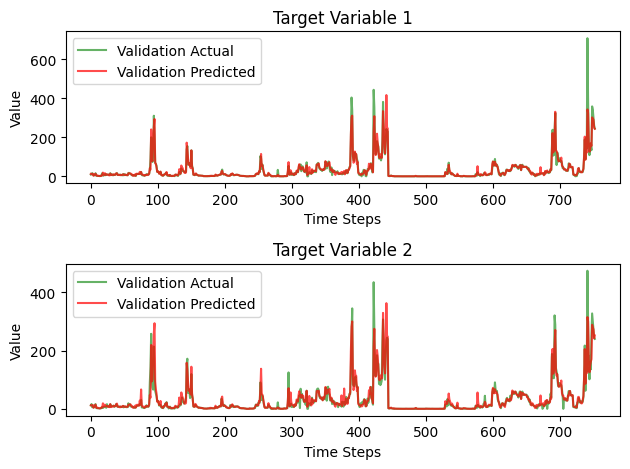

Para el fold 2 el MAE a 24 horas es 4.812512641622342 y a 48 horas es 6.323121140735814.


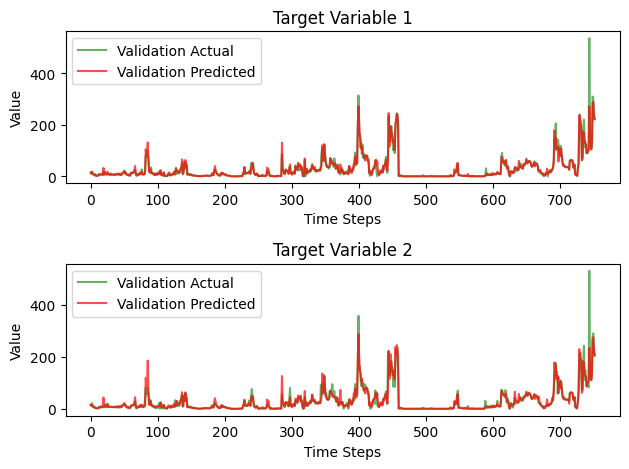

[codecarbon INFO @ 11:41:07] Energy consumed for RAM : 0.000091 kWh. RAM Power : 5.860208988189697 W
[codecarbon INFO @ 11:41:08] Energy consumed for all GPUs : 0.000034 kWh. Total GPU Power : 2.709185074914705 W
[codecarbon INFO @ 11:41:08] Energy consumed for all CPUs : 0.000723 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:41:08] 0.000847 kWh of electricity used since the beginning.


Para el fold 3 el MAE a 24 horas es 6.298364009308516 y a 48 horas es 8.137355229609934.


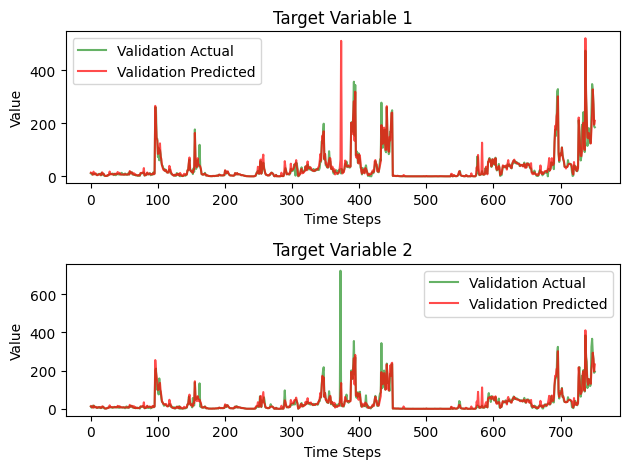

Para el fold 4 el MAE a 24 horas es 5.654376680407803 y a 48 horas es 7.987123810283694.


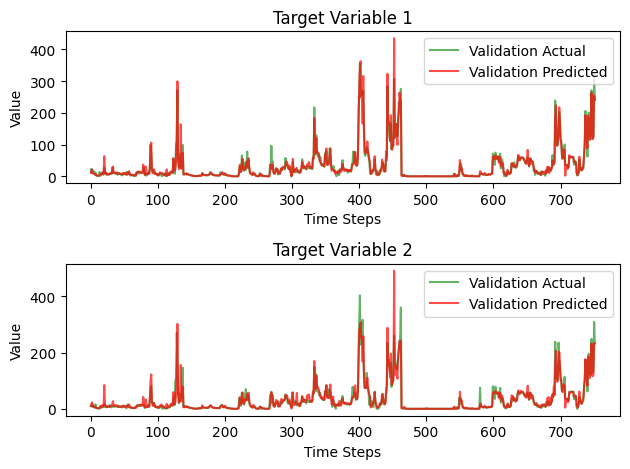

Para el fold 5 el MAE a 24 horas es 5.955866007313836 y a 48 horas es 7.753282075576246.


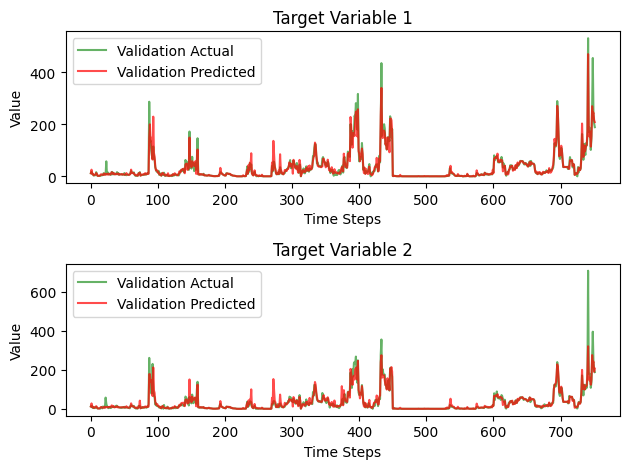

[codecarbon INFO @ 11:41:22] Energy consumed for RAM : 0.000113 kWh. RAM Power : 5.860208988189697 W


Para el fold 6 el MAE a 24 horas es 6.6236483836436095 y a 48 horas es 7.896146172650705.


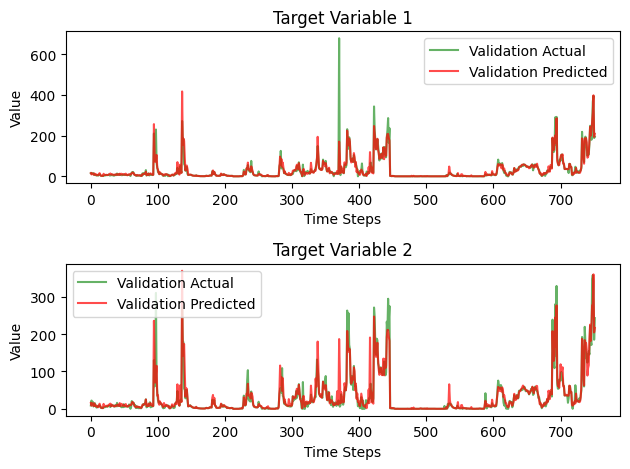

[codecarbon INFO @ 11:41:23] Energy consumed for all GPUs : 0.000043 kWh. Total GPU Power : 2.4730606153695915 W
[codecarbon INFO @ 11:41:23] Energy consumed for all CPUs : 0.000900 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:41:23] 0.001056 kWh of electricity used since the beginning.


Para el fold 7 el MAE a 24 horas es 5.891798982047877 y a 48 horas es 7.63903188829787.


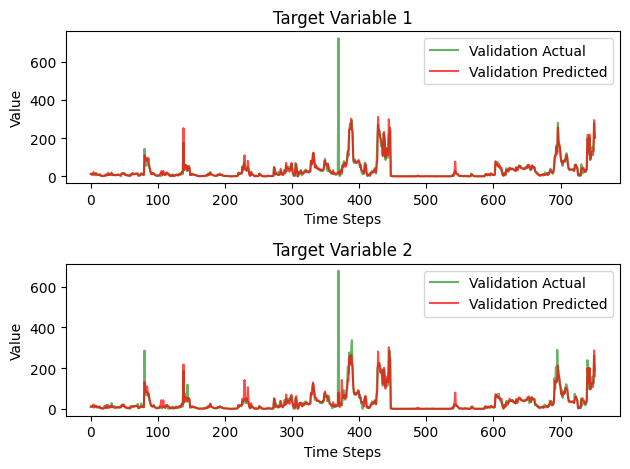

In [8]:
reg = ExtraTreesRegressor(n_estimators=100, random_state=0)
kf = KFold(n_splits=7, random_state=100 ,shuffle=True)

for k, (train, test) in enumerate(kf.split(input, target)):
    reg.fit(input[train], target[train])
    y_pred = reg.predict(input[test])

    mae = mae_cal(target[test], y_pred)

    print('Para el fold {} el MAE a 24 horas es {} y a 48 horas es {}.'.format(k+1, mae[0], mae[1]))

    plot_predictions(target[test], y_pred)

In [9]:
reg = ExtraTreesRegressor(n_estimators=100, random_state=0)

reg.fit(input, target)
y_pred = reg.predict(pred)

In [10]:
date_dict = {
    '2023-04-11': [(737, 738), (2016, 2017), (3295, 3296), (4574, 4575), (5853, 5854)],
    '2023-05-02': [(757, 758), (2036, 2037), (3315, 3316), (4594, 4595), (5813, 5814)],
    '2023-06-07': [(792, 793), (2071, 2072), (3350, 3351), (4629, 4630), (5908, 5909)],
    '2023-07-04': [(818, 819), (2097, 2098), (3376, 3377), (4655, 4656), (5934, 5935)],
    '2023-07-30': [(843, 844), (2122, 2123), (3401, 3402), (4680, 4681), (5959, 5960)],
    '2023-09-04': [(878, 879), (2157, 2158), (3436, 3437), (4715, 4716), (5994, 5995)],
    '2023-09-25': [(898, 899), (2177, 2178), (3456, 3457), (4735, 4736), (6014, 6015)],
    '2023-11-02': [(935, 936), (2214, 2215), (3493, 3494), (4772, 4773), (6051, 6052)],
    '2023-12-02': [(964, 965), (2243, 2244), (3522, 3523), (4801, 4802), (6080, 6081)],
    '2023-12-24': [(985, 986), (2264, 2265), (3543, 3545), (4822, 4823), (6101, 6102)],
    '2024-01-17': [(1008, 1009), (2287, 2288), (3566, 3567), (4845, 4846), (6124, 6125)],
    '2024-02-11': [(1032, 1033), (2311, 2312), (3590, 3591), (4869, 4870), (6148, 6149)],
    '2024-03-10': [(1059, 1060), (2338, 2339), (3617, 3618), (4896, 4897), (6175, 6176)]
}

df = pd.DataFrame(columns=["time_name", "caudal_m3/s"])
for n in range(5):
    for date_str in date_dict:
        date = pd.to_datetime(date_str)
        
        # Calculate the two following days
        next_day_1 = date + timedelta(days=1)
        next_day_2 = date + timedelta(days=2)
        
        # Create rows for "Emplazamiento n" (where n ranges from 0 to 4) for each of the next two days
        new_rows = []
        # n from 0 to 4
        new_rows.append({"time_name": f"{next_day_1.strftime('%Y-%m-%d')}_Emplazamiento {n}", "caudal_m3/s": 0})
        new_rows.append({"time_name": f"{next_day_2.strftime('%Y-%m-%d')}_Emplazamiento {n}", "caudal_m3/s": 0})
        
        # Concatenate the new rows to the DataFrame
        df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

In [11]:
df['caudal_m3/s'] = y_pred.flatten()

df.to_csv("submission.csv", index=False)

df

,time_name,caudal_m3/s
0,2023-04-12_Emplazamiento 0,2.012905
1,2023-04-13_Emplazamiento 0,2.337200
2,2023-05-03_Emplazamiento 0,3.803828
3,2023-05-04_Emplazamiento 0,4.743520
4,2023-06-08_Emplazamiento 0,15.702270
...,...,...
125,2024-01-19_Emplazamiento 4,172.500920
126,2024-02-12_Emplazamiento 4,114.329770
127,2024-02-13_Emplazamiento 4,118.699490
128,2024-03-11_Emplazamiento 4,272.696520


In [12]:
tracker.stop()

[codecarbon INFO @ 11:41:32] Energy consumed for RAM : 0.000127 kWh. RAM Power : 5.860208988189697 W
[codecarbon INFO @ 11:41:33] Energy consumed for all GPUs : 0.000052 kWh. Total GPU Power : 3.697161563355793 W
[codecarbon INFO @ 11:41:33] Energy consumed for all CPUs : 0.001012 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 11:41:33] 0.001191 kWh of electricity used since the beginning.


ref: C:\Users\Brais\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\data\private_infra\global_energy_mix.json


0.00020733746294123383